## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [42]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [43]:
df = pd.read_csv('data/StudentsPerformance.csv')

#### Show Top 5 Records

In [44]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [45]:
X = df.drop(columns=['math score'],axis=1)

In [46]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [47]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race ethnicity' variable:  ",end=" ")
print(df['race/ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental level of education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [48]:
y = df['math score']

In [49]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

In [50]:
# Create Column Transformer with 3 types of transformers
# IDENTIFY COLUMN TYPES
num_features = X.select_dtypes(exclude="object").columns  # Finds numeric columns (ints, floats)
cat_features = X.select_dtypes(include="object").columns  # Finds categorical columns (text, strings)

# IMPORT TOOLS
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# CREATE TRANSFORMERS
numeric_transformer = StandardScaler()  # Tool to scale numbers (mean=0, std=1)
oh_transformer = OneHotEncoder()        # Tool to convert categories to 0/1 codes

# COMBINE THEM INTO A PIPELINE
preprocessor = ColumnTransformer(
    [
        # RULE 1: For text columns : convert to one-hot encoding
        ("OneHotEncoder", oh_transformer, cat_features),
        
        # RULE 2: For number columns  scale them
        ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [51]:
# FIRST: Split the raw, unprocessed data # separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  # Use the original X, not transformed!
    test_size=0.2, 
    random_state=42
) 


In [52]:
#wrong :X = preprocessor.fit_transform(X)
# SECOND: Fit(train) preprocessor ONLY on training data
preprocessor.fit(X_train)  # Learn patterns from training only


ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')),
                                ('StandardScaler', StandardScaler(),
                                 Index(['reading score', 'writing score'], dtype='object'))])

In [53]:
# THIRD: Transform both sets
X_train_processed = preprocessor.transform(X_train)  # Transform training
X_test_processed = preprocessor.transform(X_test)    # Transform test using training rules

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")

Training shape: (800, 19)
Test shape: (200, 19)


In [54]:
X_train_processed

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.03079054,  0.43405338],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.9302895 ,  0.96470125],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.34544287,  1.1636942 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
        -0.52274728, -1.02522827],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.49143847, -1.02522827],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.48382733,  1.36268716]])

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [55]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [56]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_processed, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3318
- Mean Absolute Error: 4.2715
- R2 Score: 0.8739
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4133
- Mean Absolute Error: 4.2172
- R2 Score: 0.8796


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5925
- Mean Absolute Error: 5.2053
- R2 Score: 0.8072
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5173
- Mean Absolute Error: 5.1557
- R2 Score: 0.8254


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.6941
- Mean Absolute Error: 4.5025
- R2 Score: 0.8562
-----------------------

### Results

In [57]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880592
0,Linear Regression,0.879575
5,Random Forest Regressor,0.852936
7,CatBoosting Regressor,0.851831
8,AdaBoost Regressor,0.848491
6,XGBRegressor,0.827797
1,Lasso,0.825446
3,K-Neighbors Regressor,0.786089
4,Decision Tree,0.740033


## Linear Regression

In [59]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train_processed, y_train)
y_pred = lin_model.predict(X_test_processed)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 87.96


## Plot y_pred and y_test

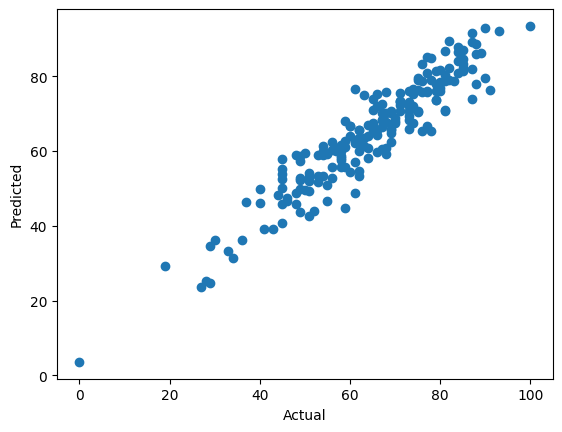

In [61]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

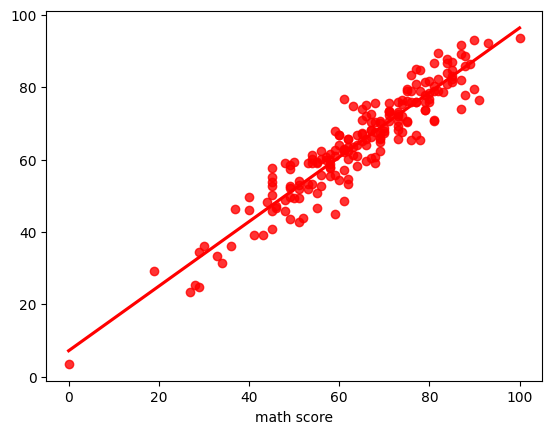

In [60]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [62]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.4375,14.5625
737,53,59.0625,-6.0625
740,80,76.7500,3.2500
660,74,76.5000,-2.5000
411,84,87.8125,-3.8125
...,...,...,...
408,52,43.8750,8.1250
332,62,62.5000,-0.5000
208,74,67.5625,6.4375
613,65,67.0625,-2.0625
